In [1]:
import numpy as np
import scipy.stats as ss
import matplotlib.pyplot as plt

In [2]:
class Mixture:
    # takes in an np array of parameters
    def __init__(self, fns, stds, weights):
        self.num_components = len(fns)
        self.stds = stds 
        self.weights = weights
        self.fns = fns
    
    def sample(self, X, n):        
        y = []
        
        mixture_idx = np.random.choice(len(weights), size=n, replace=True, p=weights)
        for i in range(n):
            mixture_id = mixture_idx[i]
            means = self.fns[mixture_id](X)
            std = self.stds[mixture_id]
            y_ = [ss.norm.rvs(m, std) for m in means]
            y.append(y_)
        return np.array(y).transpose()
    
    def prod(self, X, Y):
        all_pdfs = []
        
        for x, y in zip(X, Y):
            p = []
            means = [f(x) for f in self.fns]
            
            for m, s, w in zip(means, self.stds, self.weights):
                p.append(ss.norm.pdf(y, loc=m, scale=s))
                
            all_pdfs.append(p)
        all_pdfs = np.squeeze(np.array(all_pdfs))        
        prod = np.prod(all_pdfs, axis=0)*self.weights
        
        return prod
        
        
    def pdf(self, X, Y):
        return np.sum(self.prod(X, Y))
    
    def condition(self, X, Y):
        pdf = self.pdf(X, Y)
        prod = self.prod(X, Y)
        self.weights = prod/pdf


In [42]:
class MomentPredictionMap:
    # takes in an np array of parameters
    def __init__(self, mixture):
        self.mixture = mixture
        self.mean = self.get_mean(mixture)
        self.std = self.get_std(mixture)
        
    @staticmethod
    def get_mean(mixture):
        def mean(x):
            m = 0.
            for w, f in zip(mixture.weights, mixture.fns):
                m += w*f(x)
            return m
        return mean
    
    @staticmethod
    def get_std(mixture):
        var = 0.
        for w, std in zip(mixture.weights, mixture.stds):
            var += w**2 * std**2
        return np.sqrt(var)
    

    def pdf(self, X, Y):
        p = []
        
        for x, y in zip(X, Y):    
            p.append(ss.norm.pdf(y, loc=self.mean(x), scale=self.std))
                
        p = np.squeeze(np.array(p))        
        prod = np.prod(p, axis=0)
        
        return prod
    
    def sample(self, X, n):
        y = []
        for i in range(n):
            y_ = [ss.norm.rvs(self.mean(x), self.std) for x in X]
            y.append(y_)
        return np.array(y).transpose()
        

In [61]:
def f1(x):
    return x**2
def f2(x):
    return x
def f3(x):
    return -x

fns = [f1, f2, f3]
stds = [1., 0.5, 1.]
weights = [0.25, 0.5, 0.25]

In [62]:
m = Mixture(fns, stds, weights)

In [63]:
X = np.array([1., 2.]) 
Y = np.array([0.1, 0.3])

In [64]:
m.pdf(X,Y)

0.0017656014481578323

In [65]:
m.sample(X, 5).shape

(2, 5)

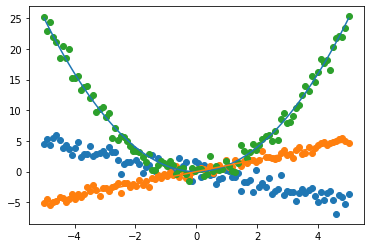

In [66]:
n_samples = 3
X = np.linspace(-5,5,100)
Y = np.array(m.sample(X, n_samples)) 

plt.plot(X, f1(X))
plt.plot(X, f2(X))
plt.plot(X, f3(X))

for i in range(n_samples):
    plt.scatter(X, Y[:, i])

In [68]:
mom_pred = MomentPredictionMap(m)

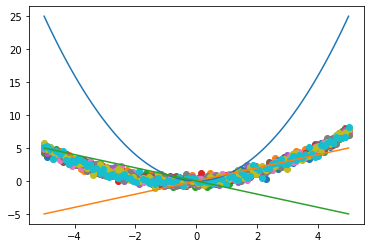

In [71]:
n_samples = 10
Y_ = mom_pred.sample(X, n_samples)
plt.plot(X, f1(X))
plt.plot(X, f2(X))
plt.plot(X, f3(X))

for i in range(n_samples):
    plt.scatter(X, Y_[:, i])

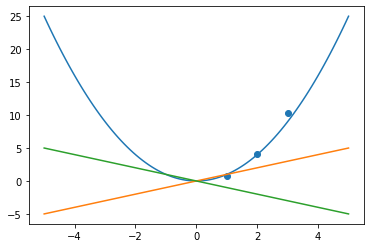

In [56]:
X = np.array([1., 2., 3.]) 
samples = m.sample(X, 1)
plt.scatter(X, samples)
X_ = np.linspace(-5,5,100)
Y_ = np.array(m.sample(X, n_samples)) 

plt.plot(X_, f1(X_))
plt.plot(X_, f2(X_))
plt.plot(X_, f3(X_))

In [57]:
m.prod(X, samples)

array([6.29668263e-03, 5.30152094e-52, 5.73988200e-50])

In [58]:
m.condition(X, samples)
m.weights

array([1.00000000e+00, 8.41954605e-50, 9.11572384e-48])

In [59]:
np.sum(m.weights)

1.0

In [60]:
mom_pred = MomentPredictionMap(m)